In [1]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Convolution1D,Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

import pickle

Populating the interactive namespace from numpy and matplotlib


/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
def lrz_rhs(t,x,sigma,beta,rho):
    return [sigma*(x[1]-x[0]), x[0]*(rho-x[2]), x[0]*x[1]-beta*x[2]];

In [3]:
end_time = 10
dt = 0.02

T = int(end_time/dt)+1
t = np.linspace(0,end_time,T,endpoint=True)
def lrz_trajectory(rho):
    sigma=10;
    beta=8/3;
    x0 = (np.random.rand(3)-.5)
    sol = integrate.solve_ivp(lambda t,x: lrz_rhs(t,x,sigma,beta,rho),[0,end_time],x0,t_eval=t,rtol=1e-10,atol=1e-11)
    return sol.y

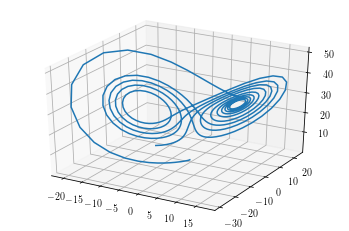

Text(0, 0.5, 'y')

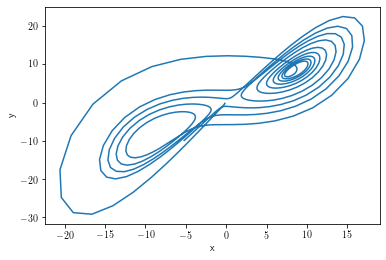

In [14]:
x = lrz_trajectory(28)
plt.figure()
plt.gca(projection='3d')
plt.plot(x[0],x[1],x[2])
plt.show()

plt.figure()
plt.plot(x[0],x[1])
plt.xlabel('x')
plt.ylabel('y')

#for ii in range(3):
#    plt.figure()
#    plt.plot(t, x[ii])
#    plt.xlabel('time')
#    plt.ylabel('state')
#    plt.show()


## Lobe Categorization and Data Generation
From the plot above, a simplist way to categorize which lobe a point is in is too see if x is greater or less than 0. 

This could be a classification or regression problem. For regression, the problem can be formulated as determining the time until the next transition. For classification, the problem can be formulated as determining if the next transition is within a specified time window. For this project, I choose the latter. 

In [4]:
def trajectory_with_transition(rho, time_window):
    # define normal vector
    c = np.array([1,0,0])
    
    # get trajectory
    x = lrz_trajectory(rho)
    
    # Lobe categorization
    classes = np.sign(np.dot(c,x))
    # find indices of transition, i.e. where there is a change between classes 
    transition_ind=np.where(np.convolve(classes,[1,-1],mode='valid')!=0)
    
    # this will be the time it takes to the next jump
    time_to_jump = np.zeros((len(x.T)))
    time_to_jump[transition_ind] = np.ones(len(transition_ind))    # ones for there are jumps 

    # count backwards from ones
    current_time_to_jump = 0
    jumping = False
    for j in range(len(time_to_jump)):
        if time_to_jump[-j]==1:
            current_time_to_jump=1
            jumping=True
        elif jumping:
            time_to_jump[-j]=current_time_to_jump
            current_time_to_jump+=1
    
    # delete the end of the data, where we don't know when the next transition is 
    valid_ind = np.where(time_to_jump!=0)[0]
    time_to_jump = time_to_jump[valid_ind]
    x = x[:,valid_ind]
    
    # Label if jump is imminent, i.e. within the specified time_window 
    jump_imminent = np.where(time_to_jump <= time_window, 1, 0)
    
    # put data together for output
    transition_dict = {'x':x, 'jump_imminent':jump_imminent}
    return transition_dict

In [5]:
time_window = 20
look_back = 15

max_iter = 100
for i in range(max_iter):
    trans_dict = trajectory_with_transition(28, time_window)
    x_data = trans_dict['x']
    
    delayed_data = np.expand_dims(x_data[:,0:-(look_back-0+1)].T, axis=1) # (T-look-back, 1, 3)
    for l in range(1, look_back):  
        delayed_data = np.concatenate((delayed_data, \
                            np.expand_dims(x_data[:,l:-(look_back-l+1)].T, axis=1)),axis=1)
        if l == (look_back-1):
            if i == 0:
                target_data = trans_dict['jump_imminent'][l:-(look_back-l+1)]
            else: 
                target_data = np.concatenate((target_data, trans_dict['jump_imminent'][l:-(look_back-l+1)]))
    if i == 0:
        input_data = delayed_data
    else: 
        input_data = np.concatenate((input_data, delayed_data),axis=0)

## Set up Neural Network

In [6]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [7]:
model = Sequential()
model.add(LSTM(3*look_back, activation="tanh", recurrent_activation="sigmoid", \
               dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

In [8]:
adam_ = optimizers.Adam(lr=.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True, clipvalue=0.5)
model.compile(loss='binary_crossentropy', optimizer=adam_, metrics=['accuracy'])

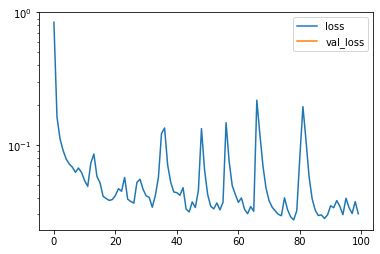

43334/43334 [==============================] - 1s 26us/step - loss: 0.0304 - acc: 0.9924


In [9]:
mpl.rcParams['text.usetex'] = False
model.fit(input_data, target_data, 
          epochs=100, batch_size=3000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [10]:
num_tests = 5

for i in range(num_tests):
    test_dict = trajectory_with_transition(28, time_window)
    x_test = test_dict['x']
    if i==0:
        trans_actual = test_dict['jump_imminent']
    else: 
        trans_actual = np.concatenate((trans_actual, test_dict['jump_imminent']))

    trans_pred_ = np.zeros_like(test_dict['jump_imminent'])
    trans_pred_[0:look_back] = test_dict['jump_imminent'][0:look_back]
    for k in range(len(trans_pred_)-look_back+1):
        pred_input = x_test[:, k:k+look_back].T
        trans_pred_[k+look_back-1] = model.predict(np.array([pred_input]))
    if i==0:
        trans_pred = trans_pred_
    else:
        trans_pred = np.concatenate((trans_pred, trans_pred_))
trans_pred = np.where(trans_pred>0.5, 1, 0)

Error rate: 
0.019470793809286072


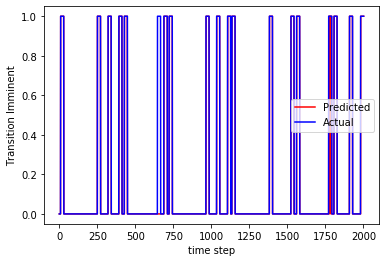

In [12]:
plt.figure()
plt.plot(trans_pred, 'r',label='Predicted')
plt.plot(trans_actual,'b',label='Actual')
plt.xlabel('time step')
plt.ylabel('Transition Imminent')
plt.legend()

# error rate
print('Error rate: ')
print(np.mean(np.abs(trans_pred-trans_actual)))

### Try a different time_window

In [119]:
time_window = 40
look_back = 15

max_iter = 100
for i in range(max_iter):
    trans_dict = trajectory_with_transition(28, time_window)
    x_data = trans_dict['x']
    
    delayed_data = np.expand_dims(x_data[:,0:-(look_back-0+1)].T, axis=1) # (T-look-back, 1, 3)
    for l in range(1, look_back):  
        delayed_data = np.concatenate((delayed_data, \
                            np.expand_dims(x_data[:,l:-(look_back-l+1)].T, axis=1)),axis=1)
        if l == (look_back-1):
            if i == 0:
                target_data = trans_dict['jump_imminent'][l:-(look_back-l+1)]
            else: 
                target_data = np.concatenate((target_data, trans_dict['jump_imminent'][l:-(look_back-l+1)]))
    if i == 0:
        input_data = delayed_data
    else: 
        input_data = np.concatenate((input_data, delayed_data),axis=0)

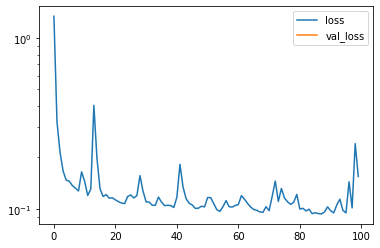

43384/43384 [==============================] - 1s 23us/step - loss: 0.1549 - acc: 0.9539


In [125]:
model = Sequential()
model.add(LSTM(3*look_back, activation="tanh", recurrent_activation="sigmoid", \
               dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

adam_ = optimizers.Adam(lr=.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True, clipvalue=0.5)
model.compile(loss='binary_crossentropy', optimizer=adam_, metrics=['accuracy'])

mpl.rcParams['text.usetex'] = False
model.fit(input_data, target_data, 
          epochs=100, batch_size=3000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [134]:
num_tests = 5

for i in range(num_tests):
    test_dict = trajectory_with_transition(28, time_window)
    x_test = test_dict['x']
    if i==0:
        trans_actual = test_dict['jump_imminent']
    else: 
        trans_actual = np.concatenate((trans_actual, test_dict['jump_imminent']))

    trans_pred_ = np.zeros_like(test_dict['jump_imminent'])
    trans_pred_[0:look_back] = test_dict['jump_imminent'][0:look_back]
    for k in range(len(trans_pred_)-look_back+1):
        pred_input = x_test[:, k:k+look_back].T
        trans_pred_[k+look_back-1] = model.predict(np.array([pred_input]))
    if i==0:
        trans_pred = trans_pred_
    else:
        trans_pred = np.concatenate((trans_pred, trans_pred_))
trans_pred = np.where(trans_pred>0.5, 1, 0)

Error rate: 
0.1295089091699261


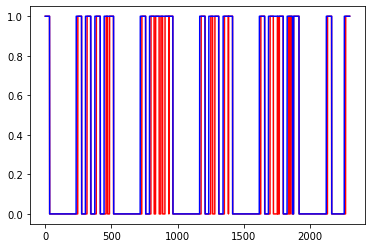

In [135]:
plt.figure()
plt.plot(trans_pred, 'r')
plt.plot(trans_actual,'b')

# error rate
print('Error rate: ')
print(np.mean(np.abs(trans_pred-trans_actual)))

# Now, it does not perform as well for a longer prediction window. 

### Try a very long time_window

In [93]:
time_window = 100
look_back = 15

max_iter = 100
for i in range(max_iter):
    trans_dict = trajectory_with_transition(28, time_window)
    x_data = trans_dict['x']
    
    delayed_data = np.expand_dims(x_data[:,0:-(look_back-0+1)].T, axis=1) # (T-look-back, 1, 3)
    for l in range(1, look_back):  
        delayed_data = np.concatenate((delayed_data, \
                            np.expand_dims(x_data[:,l:-(look_back-l+1)].T, axis=1)),axis=1)
        if l == (look_back-1):
            if i == 0:
                target_data = trans_dict['jump_imminent'][l:-(look_back-l+1)]
            else: 
                target_data = np.concatenate((target_data, trans_dict['jump_imminent'][l:-(look_back-l+1)]))
    if i == 0:
        input_data = delayed_data
    else: 
        input_data = np.concatenate((input_data, delayed_data),axis=0)

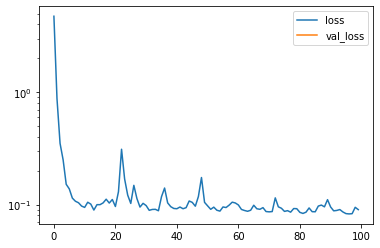

43598/43598 [==============================] - 2s 39us/step - loss: 0.0901 - acc: 0.9734


In [94]:
model = Sequential()
model.add(LSTM(3*look_back, activation="tanh", recurrent_activation="sigmoid", \
               dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

adam_ = optimizers.Adam(lr=.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True, clipvalue=0.5)
model.compile(loss='binary_crossentropy', optimizer=adam_, metrics=['accuracy'])

mpl.rcParams['text.usetex'] = False
model.fit(input_data, target_data, 
          epochs=100, batch_size=3000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [95]:
num_tests = 5

for i in range(num_tests):
    test_dict = trajectory_with_transition(28, time_window)
    x_test = test_dict['x']
    if i==0:
        trans_actual = test_dict['jump_imminent']
    else: 
        trans_actual = np.concatenate((trans_actual, test_dict['jump_imminent']))

    trans_pred_ = np.zeros_like(test_dict['jump_imminent'])
    trans_pred_[0:look_back] = test_dict['jump_imminent'][0:look_back]
    for k in range(len(trans_pred_)-look_back+1):
        pred_input = x_test[:, k:k+look_back].T
        trans_pred_[k+look_back-1] = model.predict(np.array([pred_input]))
    if i==0:
        trans_pred = trans_pred_
    else:
        trans_pred = np.concatenate((trans_pred, trans_pred_))
trans_pred = np.where(trans_pred>0.5, 1, 0)

Error rate: 
0.0353309481216458


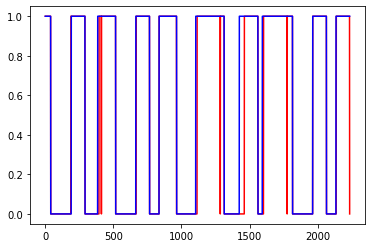

In [96]:
plt.figure()
plt.plot(trans_pred, 'r')
plt.plot(trans_actual,'b')

# error rate
print('Error rate: ')
print(np.mean(np.abs(trans_pred-trans_actual)))

Note, it may not make sense to try a larger window than this, because that will run over multiple transitions. Very large window would make fewer points considered imminent, which would create unbalanced data distribution. This could also be why the performance is good with time_window=100, as most points were considered imminent. 